# Satellite Image Processing with Deep Learning

In this notebook you will:
- Solve the EuroSAT-10 classification problem,
- to that end use Convolutional Neural Networks,
- decrease overfitting with dropout,
- decrease overfitting even further with data augmentation, and
- solve the problem with transfer learning.

First two cells provides with imports and data downloads.

## Import all necessary modules  and check TensorFlow version.

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith("2."), "You have TensorFlow version {}, 2.X is required, please upgrade.".format(tf.__version__)

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, Input

## Load and split EuroSAT-dataset.

We split the data into three subsets:
- Train: For training the Neural Network.
- Validate: To see how good the Neural Network is after each epoch.
- Test: To see how good the Neural Network is after training.

In [ ]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(
    name="eurosat/rgb", 
    split=["train[:70%]", "train[70%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)
print(info)
print("Train:   ", len(list(dataset_train_original)))
print("Validate:", len(list(dataset_validate_original)))
print("Test:    ", len(list(dataset_test_original)))

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteKCBTTD/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017

In [ ]:
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea & lake"]

def label_to_string(label):
  return class_names[label]

## Create a Deep Neural Network to solve our classification problem - Convolutional Neural Network.


# Some pointers :




> Some data visualisations of the train, validation and test data.

> Exploratory Data Analysis of the dataset.

> Accuracy plots




Notebook contains


1.   Some Visualizations of Dataset
2.   Preprocessing
3.   Convolutional Neural Network
4.   Convolutional Neural Network with Dropout
5.   CNNs With Augumentation and Dropout
6.   Accuracy Plots of all the three cases
7.   Transfer Learning
8.   Accuracy Plot










In [ ]:
# Shape of Image
for image, label in dataset_train_original:
  print(image.shape,label)
  break

(64, 64, 3) tf.Tensor(4, shape=(), dtype=int64)


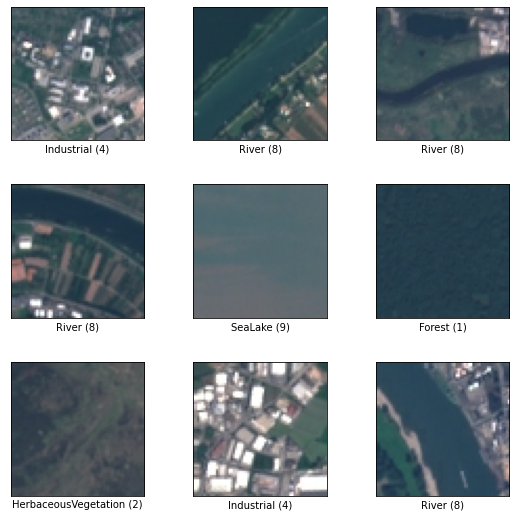

In [ ]:
ds, info = tfds.load('eurosat/rgb', split='train', with_info=True)
fig = tfds.show_examples(info,ds)

In [ ]:
# Preprocessing 
def normalization(image, label):
   return tf.cast(image, tf.float32) / 255.0, label

## FOR TRAINING DATA
#To run on multiple threads
dataset_train_original = dataset_train_original.map(normalization,num_parallel_calls=tf.data.experimental.AUTOTUNE)
# For better performance
dataset_train_original = dataset_train_original.cache()
dataset_train_original = dataset_train_original.shuffle(info.splits['train[:70%]'].num_examples)
dataset_train_original = dataset_train_original.batch(32)
dataset_train_original = dataset_train_original.prefetch(tf.data.experimental.AUTOTUNE)

## FOR VALIDATION DATA
#To run on multiple threads
dataset_validate_original = dataset_validate_original.map(normalization,num_parallel_calls=tf.data.experimental.AUTOTUNE)
# For better performance
dataset_validate_original = dataset_validate_original.cache()
dataset_validate_original = dataset_validate_original.shuffle(info.splits['train[70%:90%]'].num_examples)
dataset_validate_original = dataset_validate_original.batch(32)
dataset_validate_original = dataset_validate_original.prefetch(tf.data.experimental.AUTOTUNE)

## FOR TEST DATA
#To run on multiple threads
dataset_test_original = dataset_test_original.map(normalization,num_parallel_calls=tf.data.experimental.AUTOTUNE)
# For better performance
dataset_test_original = dataset_test_original.cache()
dataset_test_original = dataset_test_original.batch(32)
dataset_test_original = dataset_test_original.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# HYPERPARAMETERS

num_classses = len(class_names)
epochs = 50

In [ ]:
# Convolution Neural Network

model = models.Sequential([
                           Input(shape=(64,64,3)),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size=(3,3)),
                           layers.Conv2D(32,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size=(3,3)),
                           layers.Conv2D(64,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size =(3,3)),
                           layers.Flatten(),
                           layers.Dense(128,activation='relu'),
                           layers.Dense(num_classses,activation='softmax')

])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [ ]:
history = model.fit(dataset_train_original,
          validation_data=dataset_validate_original,
          epochs = epochs)

591/591 [==============================] - 5s 8ms/step - loss: 1.7411 - accuracy: 0.7194 - val_loss: 1.7548 - val_accuracy: 0.7067
Epoch 18/50
591/591 [==============================] - 5s 8ms/step - loss: 1.7346 - accuracy: 0.7259 - val_loss: 1.7442 - val_accuracy: 0.7154
Epoch 19/50
591/591 [==============================] - 5s 8ms/step - loss: 1.7358 - accuracy: 0.7258 - val_loss: 1.7444 - val_accuracy: 0.7170
Epoch 20/50
591/591 [==============================] - 5s 8ms/step - loss: 1.7243 - accuracy: 0.7351 - val_loss: 1.7386 - val_accuracy: 0.7194
Epoch 21/50
591/591 [==============================] - 5s 8ms/step - loss: 1.7197 - accuracy: 0.7414 - val_loss: 1.7316 - val_accuracy: 0.7269
Epoch 22/50
591/591 [==============================] - 5s 8ms/step - loss: 1.7010 - accuracy: 0.7598 - val_loss: 1.6814 - val_accuracy: 0.7785
Epoch 23/50
591/591 [==============================] - 5s 8ms/step - loss: 1.7003 - accuracy: 0.7604 - val_loss: 1.6853 - val_accuracy: 0.7748
Epoch 24/50

In [ ]:
# WITH DROPOUT

model = models.Sequential([
                           Input(shape=(64,64,3)),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size=(3,3)),
                           layers.Dropout(0.2),
                           layers.Conv2D(32,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size=(3,3)),
                           layers.Dropout(0.3),
                           layers.Conv2D(64,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size =(3,3)),
                           layers.Flatten(),
                           layers.Dense(128,activation='relu'),
                           layers.Dense(num_classses,activation='softmax')

])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history1 = model.fit(dataset_train_original,
          validation_data=dataset_validate_original,
          epochs = epochs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)         

In [ ]:
# WITH AUGUMENTATION

# By reading this research paper - https://www.researchgate.net/publication/335844785_DATA_AUGMENTATION_APPROACHES_FOR_SATELLITE_IMAGE_SUPER-RESOLUTION#:~:text=Data%20augmentation%20is%20a%20well,satellite%20image%20super%20resolution%20tasks.

augumentation = models.Sequential([
                                   Input(shape=(64,64,3)),
                                   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                   layers.experimental.preprocessing.RandomContrast(0.7, 1.3)
])

model = models.Sequential([
                           augumentation,
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size=(3,3)),
                           layers.Dropout(0.2),
                           layers.Conv2D(32,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size=(3,3)),
                          #  layers.Dropout(0.3),
                           layers.Conv2D(64,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(pool_size =(3,3)),
                           layers.Flatten(),
                           layers.Dense(128,activation='relu'),
                           layers.Dense(num_classses,activation='softmax')

])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.summary()
history2 = model.fit(dataset_train_original,
          validation_data=dataset_validate_original,
          epochs = epochs)

Epoch 1/50
591/591 [==============================] - 3s 5ms/step - loss: 2.1130 - accuracy: 0.3404 - val_loss: 2.0023 - val_accuracy: 0.4550
Epoch 2/50
591/591 [==============================] - 3s 5ms/step - loss: 1.9970 - accuracy: 0.4612 - val_loss: 1.9549 - val_accuracy: 0.5070
Epoch 3/50
591/591 [==============================] - 3s 5ms/step - loss: 1.9632 - accuracy: 0.4946 - val_loss: 1.9420 - val_accuracy: 0.5122
Epoch 4/50
591/591 [==============================] - 3s 5ms/step - loss: 1.9477 - accuracy: 0.5095 - val_loss: 1.9434 - val_accuracy: 0.5130
Epoch 5/50
591/591 [==============================] - 3s 5ms/step - loss: 1.9208 - accuracy: 0.5352 - val_loss: 1.9300 - val_accuracy: 0.5270
Epoch 6/50
591/591 [==============================] - 3s 5ms/step - loss: 1.8986 - accuracy: 0.5603 - val_loss: 1.8322 - val_accuracy: 0.6263
Epoch 7/50
591/591 [==============================] - 3s 5ms/step - loss: 1.8725 - accuracy: 0.5873 - val_loss: 1.7847 - val_accuracy: 0.6791
Epoch 

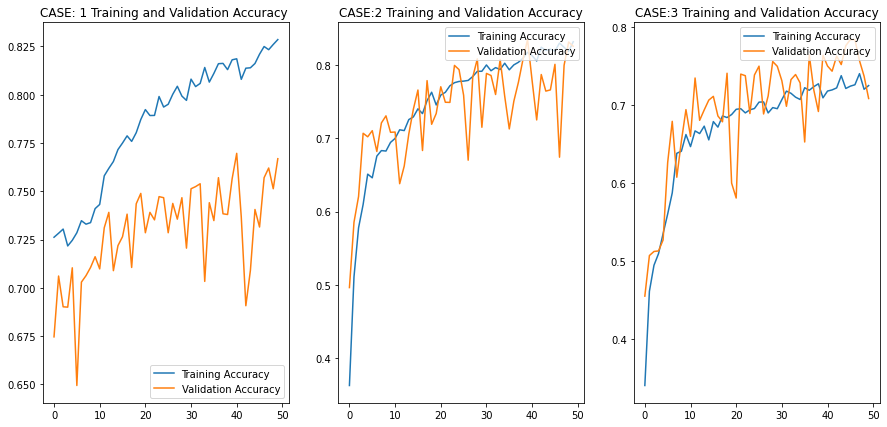

In [ ]:
# Without Dropout
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

#With Dropout
accuracy_dropout = history1.history['accuracy']
val_acc_dropout = history1.history['val_accuracy']

#With Augumentation + Dropout
accuracy_aug = history2.history['accuracy']
val_acc_aug = history2.history['val_accuracy']


epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('CASE: 1 Training and Validation Accuracy ')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, accuracy_dropout, label='Training Accuracy')
plt.plot(epochs_range, val_acc_dropout, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('CASE:2 Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, accuracy_aug, label='Training Accuracy')
plt.plot(epochs_range, val_acc_aug, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('CASE:3 Training and Validation Accuracy')
plt.show()

In [19]:
# WITH TRANSFER LEARNING

augumentation = models.Sequential([
                                   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                   layers.experimental.preprocessing.RandomContrast(0.7, 1.3)
])

base_model = tf.keras.applications.DenseNet201(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(64,64,3))
x = augumentation(inputs)
x = base_model(x,training= False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classses,activation='softmax')(x)

model = models.Model(inputs,x)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_final = model.fit(dataset_train_original,
                          validation_data=dataset_validate_original,
                          epochs= epochs)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1920)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                19210     
Total params: 18,341,194
Trainable params: 19,210
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/50
591/591 [==============================] - 20s 34ms/step - loss: 2.0349 - accuracy: 0.4938 

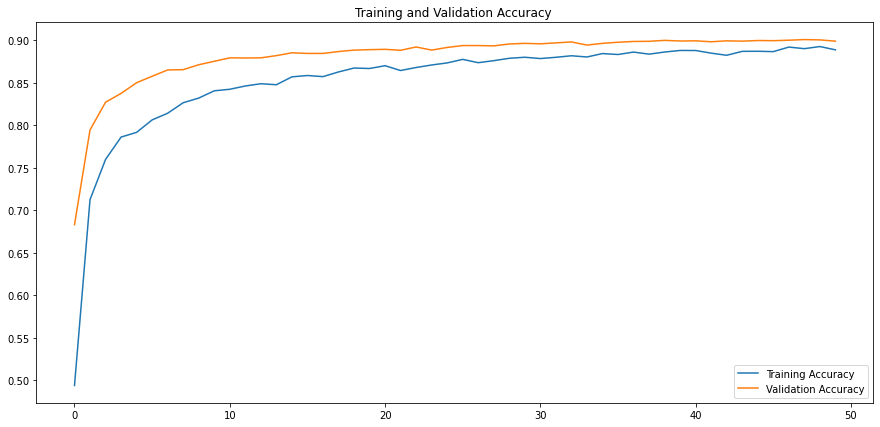

In [20]:
# Transfer Learning
accuracy = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')
plt.show()